
**Anna Maria Llopart**

U19965

# Canonical genetic algorithm.

In this practice we will implement the canonical genetic algorithm in order to solve the same problem as in practice 2: finding the coefficients of a line in order to find the line that best fits a series of observed points.

After generating the data, we'll define a series of functions that will be used to implement parts of the algorithm. This will allow us to check that these different parts are working correctly. With small further modifications, we will eventually unify them into the full algorithm implementation.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from IPython import display

**P1.** As in Exercise 2, create the observations from a straight line with some noise:

Remember the equation of the line $y=a x + b$. 

1. Define the initial coefficients ($a_0$, $b_0$) by choosing values within the interval [-5,5] ($a_0 \in [-5,5]$, $b_0 \in [-5,5 ]$).
2. Generate 10 points equally spaced between 1 and 10 and store them in the variable $x$. Assign to each point the value that defines the line.
3. Add Gaussian noise to each point (mean 0, standard deviation 1). These will be your observations ($y_{obs}$ in the MSE formula below)
4. View the observations along with the initial line.

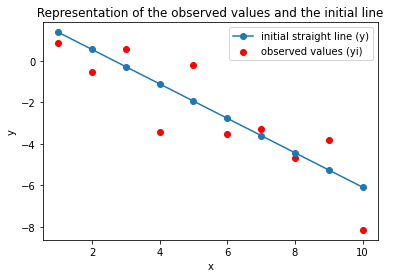

The value of a is:  -0.8297799529742598
The value of b is:  2.2032449344215808


In [5]:
np.random.seed(1) # We initialize seed
a = np.random.uniform(-5,5) #intial coefficients, correspond to both genes of the genotype
b = np.random.uniform(-5,5)
x = np.linspace(1,10,10) #equidistantly distributed points
y = a*x + b
s = np.random.normal(0,1, 10) #gaussian noise
yi = y + s #observations (they have noise)
plt.plot(x,y,marker='o', label='initial straight line (y)')
plt.scatter(x,yi,color='red',label='observed values (yi)')
plt.xlabel('x') 
plt.ylabel('y') 
plt.title(" Representation of the observed values and the initial line ")
plt.legend()
plt.show()
print("The value of a is: ", a)
print("The value of b is: ", b)

**P2.** Get the individual2 class from exercise 3 and name it "individual".

**P2.1** Modify the individual class to add the fitness attribute. Modify the initialization function so that fitness can also be specified when creating an instance, and otherwise takes the value 0.

In [6]:
class Individual:                 
    def __init__(self, ngenes =1, genotype = [], boundslow = [-5,-5], boundshigh = [5,5], fitness = 0): #boundslow is a list with the lower limits for each gene. boundshigh the same for upper limits.
        self.ngenes = ngenes
        self.genotype = np.array(genotype)
        self.boundslow = boundslow
        self.boundshigh = boundshigh
        self.fitness = fitness # We add fitness attribute. 
        if self.genotype.size == 0: # If the attribute has not been determined, the function described below is used to generate a random genotype
            self.genotype = self.set_random_genotype(ngenes, boundslow, boundshigh)
            
                                                
    def set_random_genotype(self, ngenes, boundslow,boundshigh): 
        genot = [] # Empty list of the genotype that will be created randomly
        for i in range(ngenes): # According to the number of genes, each position of the genotype is created with random
            r = np.random.uniform(boundslow[i],boundshigh[i]) 
            genot.append(r)

        return(genot) # We return the genotype created so that it can be used in the attribute and initialize it

**P2.2.** Define the *assign_fitness* function, which takes as an argument an individual of the individual class and assigns the corresponding fitness (1/MSE) to the *fitness* attribute.

Remember the MSE formula:

$E=\frac{1}{n}\Sigma_{i=0}^{n-1}(y_{i,obs}-y_{i,pred})^2$



In [9]:
# Based on the observations and the individual in question, we calculate how good the solution is with its fitness.
def assign_fitness(individu,x,yi):  
    a = individu.genotype[0] # a and b are the first two genes of the genotype. 
    b = individu.genotype[1]
    ypred = a*x + b 
    mse = np.mean(np.square(ypred-yi)) #formule
    fitness = 1 /mse
    individu.fitness = fitness # assigns it to the corresponding individual

**P3**. Mutation

3.1 Next, define a mutation function *mutate* that applies a Gaussian mutation: for each gene in an individual's genotype, with probability *p_mut* the value can be changed by adding a random number drawn from a normal distribution centered on 0 and with standard deviation $\sigma$.

The function must take 3 arguments: an individual of the individual class, and the parameters *p_mut* and *sigma*.

In [10]:
def mutate(individual, p_mut, sigma): 
    for i in range(len(individual.genotype)): # Let's go through each gene of the genotype
        r = np.random.uniform(0,1) # We generate a random value to determine what condition the probability is in
        if r <= p_mut: # Only with the specified probability
            mutacion = np.random.normal(0,sigma)
            individual.genotype[i] = mutacion   # The gene is modified by mutation.
    return(individual)

**P4.** Selection

P4.1. Implement a function that, given an array of fitness values, not necessarily in order, selects one of the fitnesses according to "fitness-proportional selection":

Given the fitnesses in increasing order $[f_0, f_1, \cdots, f_{n-1}]$, generate a random number $r \in [0, \sum_{j=0}^{n-1}f_{ j}$] and choose the index $k$ such that:

$\sum_{j=0}^{k-1}f_j \le r < \sum_{j=0}^{k}f_j$

Example: Imagine you have the fitnesses [15,10,20, 14]. In this case, the cumulative value of ordered fitnesses: [10, 24, 39, 59]. Imagine you extract the value r=28.5. The function should in this case return fitness with index 2 (39), since 28.5 is between 24 and 39.

You can first code this particular case, then add $r$ to be a random number within the corresponding range, generalize it to any fitness array, and turn it into a function. Also check that if the extracted number was 5, it would return the individual with index 0 in the example case.


In [17]:
def fitness_proportionate_selection(lista_fit):
    arr_fit = np.array(lista_fit)
    ordenada = np.sort(arr_fit) 
    f = []
    suma = 0
    for i in range(len(ordenada)):  # We do the cumulative sum of the ordered list
        suma = suma + ordenada[i]
        f.append(suma)

    r = np.random.uniform(0,f[-1]) # We create a random number between 0 and the last value of the cumulative list

    for i in range(len(f)): 
        if r >= f[i] and r <= f[i+1]: # We are looking for an interval in which the created random number is included
            k = i + 1       
        elif r < f[0]: 
            k  = 0
    return k  # We return the corresponding index

P4.2. Implement the *select* function that takes as argument the list of individuals corresponding to the population, and returns two different ones (they will be the parents in the implementation of the algorithm), according to the *fitness proportional selection* process implemented on top.

Slightly modify what you implemented in the function in point 4.1: get the fitness array of individuals, sort the fitnesses, select an individual, create a second array of individuals and fitness without the one you already selected, recalculate commands and select a second individual.

In [18]:
import copy
# Function to make a copy of the Individual class
def copy_individual(individual):
    ind = copy.deepcopy(individual)
    assign_fitness(ind,x,yi) # In the copy we assign the fitness
    return(ind)

def select(lista_individuos):
    clist = [] 
    lista_fit = []
    for inn in lista_individuos: # We fill in the copy list with which we will work, keeping the original intact.
        clist.append(copy_individual(inn))
    for innn in clist: # We fill the fitness list
        lista_fit.append(innn.fitness)  
    # First we obtain the index that will correspond to the first father:  
    fitness1 = fitness_proportionate_selection(lista_fit)
    padre1=lista_individuos[fitness1]
    assign_fitness(padre1,x,yi)
    del clist[fitness1] # we remove the father from the copied list.
    # Same for the second father    
    lista_fit=[]
    for inn in clist:
        lista_fit.append(inn.fitness)  # We add the fitness attributes to the list
    fitness2=fitness_proportionate_selection(lista_fit)
    padre2=clist[fitness2]
    assign_fitness(padre2,x,yi)
    return(padre1,padre2) # we return both selected parents

**P5**. Crossover.

Implement the *mate* function that takes 3 arguments: 2 parents ( $p_1$ , $p_2$ ) and $\eta$ , and returns two children ($f_1$ , $f_2$ ). The genotypes of the children are determined according to the method of *simulated binary crossover*:
$$
f_1=(1/2)[(1+\beta)p_1 + (1-\beta)p_2]\\
f_2=(1/2)[(1-\beta)p_1 + (1+\beta)p_2]
$$

where $\beta$ is chosen according to:
$$
\beta=\begin{cases}
(2u)^{\frac{1}{\eta+1}}, & \text{if } u \leq 0.5\\
\frac{1}{2(1-u)}^{\frac{1}{\eta+1}}, &\text{if } u > 0.5 \\
\end{cases}
$$
and $u$ is a random number drawn between [0,1] and $\eta$ is the *crowding factor* or *distribution index*.

To make the children, you can first make a copy of the parent and then apply the crossover.

Check that the function does what you expect: create two individuals with two known genotypes, and see what genotypes the children returned by your *mate* function have. Check that the genotypes of the parents remain intact.

In [19]:
#Crossover: 
#Function mate:     
def mate(p1,p2,n=0.6):
    p1copy = copy_individual(p1) # First we make copies of the parents. We use the function used previously
    p2copy = copy_individual(p2)
    f1_genotype = [] # Empty genotype lists for children
    f2_genotype =[]
    # We apply the simulated binary crossover method:
    u = np.random.uniform(0,1)
    if u <= 0.5: 
        beta = (2*u)**(1/(1+n))
    else: 
        beta = (1/(1-u))**(1/(1+n))
    for i in range(len(p1copy.genotype)): 
        f1_genotype.append((1/2)*((1+beta)*p1copy.genotype[i] + (1-beta)*p2copy.genotype[i]))
        f2_genotype.append((1/2)*((1-beta)*p1copy.genotype[i] + (1+beta)*p2copy.genotype[i]))
    # We create the instances of the Individual class with the genotypes created for the children
    f1 = Individual(2, f1_genotype)
    f2 = Individual(2,f2_genotype)
    return(f1,f2) # We return the created instances.

**P6**. Genetic algorithm.

Finally, define a function that runs the canonical genetic algorithm using the individual class to define the individuals and the *assign_fitness*, *select*, *mate*, *mutate* functions.

The function must take as keyword arguments all the arguments your functions need, plus whatever is needed to specify the population of individuals and the proper functioning of the algorithm.

Make the best individual of each generation always pass to the next.

Let the crossover probability between two parents be p_crossover, and let the mutation of each child after crossover run only with probability p_mut_ind.

Make sure that at the end of the run you can plot the average and maximum fitness at each iteration.



In [20]:
# The following algorithm iterates 200 times to represent the evolution during 100 generations. Specifically, a population is evaluated
# of 50 individuals. Each time it is passed to the next generation, the number of individuals is preserved, and it is maintained
# individual with the best fitness of the previous generation.

def algoritmo_genetico(x,yi, p_mut, sigma,ngenes =2, genotype = [], boundslow = [-5,-5], boundshigh = [5,5], fitness = 0, n=0.6):
    # Let's define the hyperparameters:
    generacion=[] # List that will contain the individuals of the generation in question
    mediana = []  # List that will contain the average fitness values for the graphic representation
    maxima = [] # Idem for maximum fitness values
    it = [] # Vector of iterations
    # First we initialize the first generation, randomly creating individuals of 2 genes.
    for i in range(50):
        individu=Individual(ngenes =2,genotype=[], boundslow = [-5,-5], boundshigh = [5,5], fitness = 0)        
        generacion.append(individu)
    
    for iteracion in range(100): # We determine the iterations that our algorithm will run, how many generations will we consider
        lista_gen_fit=[] # List to fill with the fitness of the population for each generation
        # For each individual we calculate their fitness and add it to the list:
        for ind in generacion:
            assign_fitness(ind,x,yi)
            lista_gen_fit.append(ind.fitness)
            
        mejor_ind=max(lista_gen_fit) # We find the best fitness
        next_generation = [] 
        for i in generacion:
            if i.fitness == mejor_ind:
                next_generation.append(i) # We preserve in the next generation the individual with the best fitness.
        # For the rest, we do the select and mate process:
        for i in range(int(len(generacion)/2)): # We consider half of the generation since the functions return parents of children
            select_gen=select(generacion) # this returns two parents
            hijos = mate(select_gen[0], select_gen[1], n) # returns two children 
            # We mutate the children before including them in the next generation:
            hijo1_mutado = mutate(hijos[0], p_mut,sigma)
            hijo2_mutado = mutate(hijos[1], p_mut, sigma) 
            next_generation.append(hijo1_mutado)
            # We only add the second child of each pair if there is still space in the new generation, otherwise the process is cut short
            if len(next_generation) < len(generacion):
                next_generation.append(hijo2_mutado)   
        # Finally we collect the average and maximum values of the fitness of each generation for the graphic representation
        mediana.append(np.mean(lista_gen_fit))
        maxima.append(mejor_ind)
        it.append(iteracion)

        generacion = next_generation # We update the generation list
        
        
    # Finally we evaluate the results of the algorithm graphically:
    plt.plot(it,mediana, label='Mean Fitness') # Median fitness function per iteration/generation
    plt.plot(it,maxima, label='Maximum Fitness') # Function of maximum fitness
    plt.xlabel('Generation') 
    plt.ylabel('Fitness') 
    plt.title(" Evolution of average and maximum fitness over 100 generations ")
    plt.legend()
    plt.show()

    return generacion




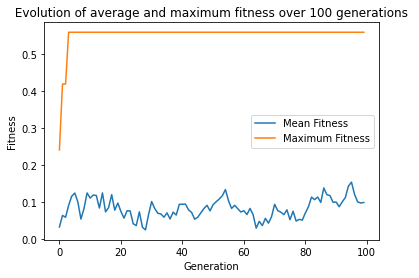

In [21]:
np.random.seed(7)
# We call the function
result=algoritmo_genetico(x,yi, p_mut=0.4, sigma=0.3,ngenes =2, genotype = [], boundslow = [-5,-5], boundshigh = [5,5], fitness = 0, n=0.6)


Run the algorithm for different seeds. Make graphs of the results obtained (the line corresponding to the $a$ and $b$ found together with the observations) and comment briefly on them.

Seed 0


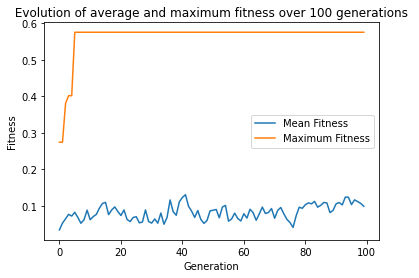

Seed 1


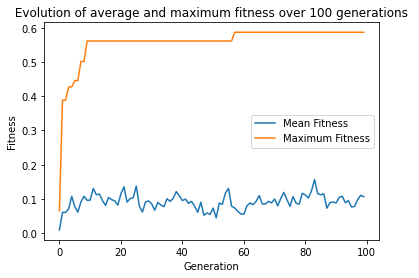

Seed 2


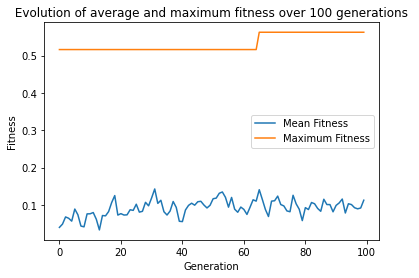

Seed 3


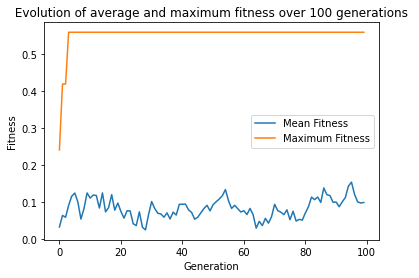

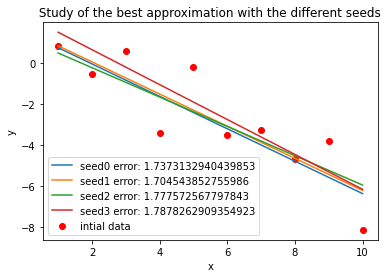

In [22]:
# The objective is to find the different prediction lines generated with the a and b values of the individuals. For the
# best prediction that fits the initial observations, we must take the best individual of the last generation, well
# the one that has a smaller error with respect to the initial observations is called "better".
# By running it with different seeds, we will get different samples of what the best individuals have become. 


x = np.linspace(1,10,10) # equidistantly distributed points
a_list = []
b_list = []
# Let's create the seeds, the previous ones have already been used
for i in range(4): 
    np.random.seed(i+4)
    print("Seed", i)
    gen = algoritmo_genetico(x,yi, p_mut=0.4, sigma=0.3,ngenes =2, genotype = [], boundslow = [-5,-5], boundshigh = [5,5], fitness = 0, n=0.6)
    # We calculate fitness to find the best individual
    lista_gen_fit=[] 
    for ind in gen:
        assign_fitness(ind,x,yi)
        lista_gen_fit.append(ind.fitness)
    mejor_ind=max(lista_gen_fit)
    for i in gen:
        if i.fitness == mejor_ind: # We store in a and b the genes of the best genotype
            a_list.append(i.genotype[0]) 
            b_list.append(i.genotype[1])
# We create the straight lines
rectas=[]
errores=[]
for i in range(len(a_list)):
    y1 = a_list[i]*x + b_list[i] 
    rectas.append(y1)
    mse = np.mean(np.square(y1-yi)) #formule
    errores.append(mse)

#plot
plt.figure()
for i in range(len(a_list)):
    plt.plot(x, rectas[i], label='seed'+str(i) + ' error: ' + str(errores[i]))
plt.scatter(x,yi,color='red',label='intial data')
plt.title(" Study of the best approximation with the different seeds ")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

**ANSWER:** We can see that all the lines created are quite similar. But if we look more closely, we see that those with the lowest error are the ones that lead to the highest maximum fitness, since the error is inversely proportional to the fitness. This is explained by the fact that when iterating through several generations we obtain a more optimal maximum fitness each time since this is preserved throughout the generations. As in each iteration there are mutations, the most favored solution is getting better.